In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [37]:
IMAGE_SIZE=160
BATCH_SIZE=32
EPOCHS=20

In [3]:
#API for loading images from directory
data=tf.keras.preprocessing.image_dataset_from_directory(
    "trainingCarD",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1840 files belonging to 2 classes.


In [4]:
class_names=data.class_names
class_names

['00-damage', '01-whole']

In [5]:
len(data)             

58

(32, 160, 160, 3)
[0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0]


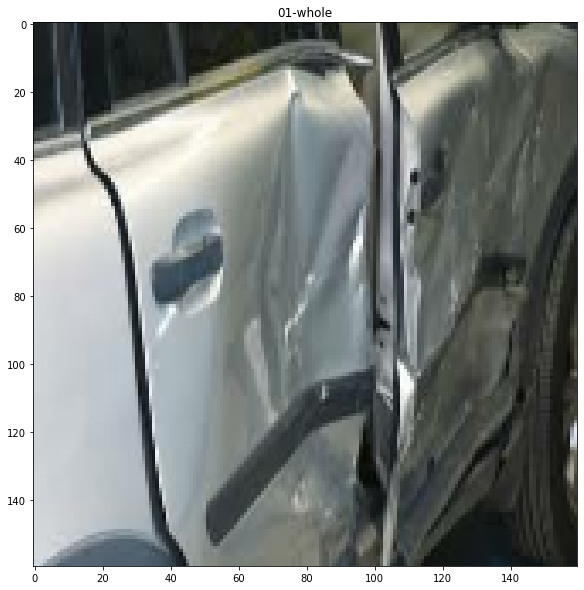

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    print(image_batch.shape)
    print(label_batch.numpy())

In [8]:
#Train and test dataset split (manually)
def test_train_split(data,train_split,test_split,shuffle,shuffle_size):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*data_size)
    test_size=int(test_split*data_size)
    
    train_data=data.take(train_size)
    test_data=data.skip(train_size)
    
    return train_data,test_data

In [9]:
train_data,test_data=test_train_split(data=data,train_split=0.8,test_split=0.2,shuffle=True,shuffle_size=10000)

In [10]:
len(train_data)

46

In [11]:
len(test_data)

12

In [12]:
#For performance improvement
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#Now we will scale the images with data augmentation 
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)                                   
])

In [38]:
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (32, 158, 158, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (32, 79, 79, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (32, 77, 77, 64)          18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (32, 38, 38, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 36, 36, 64)         

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [40]:
history=model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=test_data
)

Epoch 1/20
46/46 [==============================] - 37s 791ms/step - loss: 0.7730 - accuracy: 0.5004 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 2/20
46/46 [==============================] - 38s 815ms/step - loss: 0.6846 - accuracy: 0.5332 - val_loss: 0.6747 - val_accuracy: 0.5625
Epoch 3/20
46/46 [==============================] - 37s 808ms/step - loss: 0.6703 - accuracy: 0.6140 - val_loss: 0.6181 - val_accuracy: 0.6667
Epoch 4/20
46/46 [==============================] - 38s 832ms/step - loss: 0.6258 - accuracy: 0.6403 - val_loss: 0.5824 - val_accuracy: 0.6979
Epoch 5/20
46/46 [==============================] - 39s 849ms/step - loss: 0.5528 - accuracy: 0.7144 - val_loss: 0.7777 - val_accuracy: 0.6250
Epoch 6/20
46/46 [==============================] - 38s 819ms/step - loss: 0.5189 - accuracy: 0.7349 - val_loss: 0.5432 - val_accuracy: 0.7370
Epoch 7/20
46/46 [==============================] - 40s 860ms/step - loss: 0.5921 - accuracy: 0.6958 - val_loss: 0.9911 - val_accuracy: 0.5885

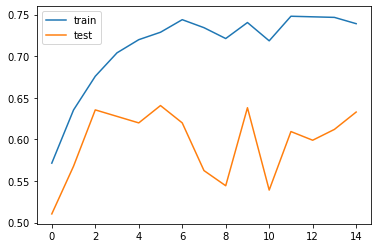

In [32]:
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.legend()
plt.show()

In [33]:
print('Test accuracy achieved', history.history['val_accuracy'][-2])

Test accuracy achieved 0.6119791865348816
